# Automated Doom with Deep Q-learning, in Pytorch

A Colaboratory notebook for GradientCrescent, by Adrian Yijie Xu.

If you enjoyed this notebook, please consider leaving a star on the GradientCrescent Github (https://github.com/EXJUSTICE/GradientCrescent), and visting the publication for more articles on applied and theoretical aspects of AI (https://medium.com/@adrianitsaxu).


## Setup

First we import all the necessary libraries. This may take a significant time, but should only be done once per session. After execution, make sure to restart the runtime.

If you wish rerun the notebook, make sure to comment it out. </font> 


In [ ]:
#Visualization cobe for running within Colab
!sudo apt-get update
!sudo apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev libopenal-dev timidity libwildmidi-dev unzip

# Boost libraries
!sudo apt-get install libboost-all-dev

# Lua binding dependencies
!apt-get install liblua5.1-dev
!sudo apt-get install cmake libboost-all-dev libgtk2.0-dev libsdl2-dev python-numpy git
!git clone https://github.com/shakenes/vizdoomgym.git
!python3 -m pip install -e vizdoomgym/



Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [232 kB]
Get:

In [ ]:
!pip install av

     |████████████████████████████████| 36.9MB 82kB/s 


Inspect the environment. You'll need to restart the runtime for it to work

In [ ]:

#Check the environment. You'll need to restart the runtime for it to work
import gym
import vizdoomgym
!
env = gym.make('VizdoomDefendLine-v0')

# use like a normal Gym environment
state = env.reset()
state, reward, done, info = env.step(env.action_space.sample())
print(state.shape)
# env.render()
env.close()

Cannot connect to "None"
(240, 320, 3)


3
(240, 320, 3)


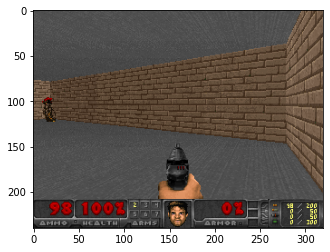

In [ ]:
import gym
import vizdoomgym

env = gym.make('VizdoomDefendLine-v0')
n_outputs = env.action_space.n
print(n_outputs)


observation = env.reset()

import matplotlib.pyplot as plt


for i in range(22):
  
  if i > 20:
    print(observation.shape)
    plt.imshow(observation)
    plt.show()

  observation, _, _, _ = env.step(1)

In [ ]:
import numpy as np


from collections import deque, Counter
import random
from datetime import datetime
from __future__ import division
from __future__ import print_function
from vizdoom import *
import itertools as it
from random import sample, randint, random
from time import time, sleep
import numpy as np
import skimage.color, skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from tqdm import trange



## Preprocessing

We'll define a set of wrappers to modify our gym environment to provide preprocessed observations.

We’ll start defining a wrapper to repeat every action for a number of frames, and perform an element-wise maxima in order to increase the intensity of any actions. 

Next, we define the preprocessing function for our observations. We’ll make our environment symmetrical by converting it into the Box space, swapping the channel integer to the front of our tensor, and resizing it to an area of (84,84) from its original (320,480) resolution. We’ll also greyscale our environment, and normalize the entire image by dividing by a constant.

Next, we create a wrapper to handle frame-stacking. The objective here is to help capture motion and direction from stacking frames, by stacking several frames together as a single batch. In this way, we can capture position, translation, velocity, and acceleration of the elements in the environment. With stacking, our input adopts a shape of (4,84,84,1).

In [ ]:
#11072020 Utililities support class

import collections
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gym

def plot_learning_curve(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Episodes", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Average Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    

class RepeatActionAndMaxFrame(gym.Wrapper):
  #input: environment, repeat
  #init frame buffer as an array of zeros in shape 2 x the obs space
    def __init__(self, env=None, repeat=4, clip_reward=False, no_ops=0,
                 fire_first=False):
        super(RepeatActionAndMaxFrame, self).__init__(env)
        self.repeat = repeat
        self.shape = env.observation_space.low.shape
        self.frame_buffer = np.zeros_like((2, self.shape))
        self.clip_reward = clip_reward
        self.no_ops = no_ops
        self.fire_first = fire_first

    def step(self, action):
        t_reward = 0.0
        done = False
        for i in range(self.repeat):
            obs, reward, done, info = self.env.step(action)
            if self.clip_reward:
                reward = np.clip(np.array([reward]), -1, 1)[0]
            t_reward += reward
            idx = i % 2
            self.frame_buffer[idx] = obs
            if done:
                break

        max_frame = np.maximum(self.frame_buffer[0], self.frame_buffer[1])
        return max_frame, t_reward, done, info

    def reset(self):
        obs = self.env.reset()
        no_ops = np.random.randint(self.no_ops)+1 if self.no_ops > 0 else 0
        for _ in range(no_ops):
            _, _, done, _ = self.env.step(0)
            if done:
                self.env.reset()
        #Fire first seems quite useless, probably meant for something like space invader
        if self.fire_first:
            assert self.env.unwrapped.get_action_meanings()[1] == 'FIRE'
            obs, _, _, _ = self.env.step(1)

        self.frame_buffer = np.zeros_like((2,self.shape))
        self.frame_buffer[0] = obs

        return obs

class PreprocessFrame(gym.ObservationWrapper):
  #set shape by swapping channels axis
	#set observation space to new shape using gym.spaces.Box (0 to 1.0)
    def __init__(self, shape, env=None):
        super(PreprocessFrame, self).__init__(env)
        self.shape = (shape[2], shape[0], shape[1])
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0,
                                    shape=self.shape, dtype=np.float32)

    def observation(self, obs):
        new_frame = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized_screen = cv2.resize(new_frame, self.shape[1:],
                                    interpolation=cv2.INTER_AREA)
        new_obs = np.array(resized_screen, dtype=np.uint8).reshape(self.shape)
        new_obs = new_obs / 255.0

        return new_obs

class StackFrames(gym.ObservationWrapper):
  #init the new obs space (gym.spaces.Box) low & high bounds as repeat of n_steps. These should have been defined for vizdooom
  #WE may not have to use boxes in ur final model. But we can keep it for now
  #Create a return a stack of observations
    def __init__(self, env, repeat):
        super(StackFrames, self).__init__(env)
        self.observation_space = gym.spaces.Box(
                            env.observation_space.low.repeat(repeat, axis=0),
                            env.observation_space.high.repeat(repeat, axis=0),
                            dtype=np.float32)
        self.stack = collections.deque(maxlen=repeat)

    def reset(self):
        self.stack.clear()
        observation = self.env.reset()
        for _ in range(self.stack.maxlen):
            self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

    def observation(self, observation):
        self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

#This shape command should not be 84,84,1 take a look at what we went with in our TF example
#Note how fire_first is false here, probably useless in the context of Pong
def make_env(env_name, shape=(84,84,1), repeat=4, clip_rewards=False,
             no_ops=0, fire_first=False):
    env = gym.make(env_name)
    env = PreprocessFrame(shape, env)
    env = RepeatActionAndMaxFrame(env, repeat, clip_rewards, no_ops, fire_first)
    
    env = StackFrames(env, repeat)

    return env

Next, let’s define our model, a deep Q-network. This is essentially a three layer convolutional network that takes preprocessed input obserations, with the generated flattened output fed to a fully-connected layer, generating probabilities of taking each action in the game space as an output.

The output layer is a fully-connected linear layer with a single output for each valid action (between 4 and 18 in the Atari games)

In [ ]:
##11072020 New DeepQNetwork class. Notice th number of filters, and the dimensions. This may work better
# Interesting note, the use of the name is needed for saving checkpoints, so it might not be necessary
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, name, input_dims, chkpt_dir):
        super(DeepQNetwork, self).__init__()
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        self.conv1 = nn.Conv2d(input_dims[0], 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        fc_input_dims = self.calculate_conv_output_dims(input_dims)

        self.fc1 = nn.Linear(fc_input_dims, 512)
        self.fc2 = nn.Linear(512, n_actions)

        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)

        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def calculate_conv_output_dims(self, input_dims):
        state = T.zeros(1, *input_dims)
        dims = self.conv1(state)
        dims = self.conv2(dims)
        dims = self.conv3(dims)
        return int(np.prod(dims.size()))

    def forward(self, state):
        conv1 = F.relu(self.conv1(state))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))
        # conv3 shape is BS x n_filters x H x W
        conv_state = conv3.view(conv3.size()[0], -1)
        # conv_state shape is BS x (n_filters * H * W)
        flat1 = F.relu(self.fc1(conv_state))
        actions = self.fc2(flat1)

        return actions

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

## Storing Replay Memories

In this section we will create a mechanism for the agent to keep track of states, actions, rewards, new states, and the final state.

All of these factors will be used in the calculation of the Target for the loss function of the DQN.

For maximum flexibility of the agent the memory should accomodate states with an arbitrary shape.

We should also sample from the memory uniformly, meaning each memory will have an equal probability of being sampled, and we should not repeat memories.


In [ ]:
#11072020 New ReplayMemory Class

import numpy as np

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    #Identify index and store  the the current SARSA into batch memory
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)
        #I believe batch here is creating a list limit that is acquired through max_mem, whihch we use to subselect memory
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

## Agent Class

Our agent be using an epsilon greedy policy with a decaying exploration rate, in order to maximize exploitation over time. To learn to predict state-action-values that maximize our cumulative reward, our agent will be using the discounted future rewards obtained by sampling the memory.

You’’ll notice that we initialize two copies of our DQN as part of our agent, with methods to copy weight parameters of our original network into a target network. This dual-network approach allows us to generate data during the training process using an existing policy while still optimizing our parameters for the next policy iteration, reducing loss oscillations.

In [ ]:
#11072020 New self-contained DQNAgent Class

import numpy as np
import torch as T
#from deep_q_network import DeepQNetwork
#from replay_memory import ReplayBuffer

class DQNAgent(object):
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, algo=None, env_name=None, chkpt_dir='tmp/dqn'):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        self.algo = algo
        self.env_name = env_name
        self.chkpt_dir = chkpt_dir
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0

        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        self.q_eval = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_eval',
                                    chkpt_dir=self.chkpt_dir)

        self.q_next = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_next',
                                    chkpt_dir=self.chkpt_dir)

    #Epsilon greedy action selection
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation],dtype=T.float).to(self.q_eval.device)
            actions = self.q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()
    #Make sure you understand this line by line
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_memory()
        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions]
        q_next = self.q_next.forward(states_).max(dim=1)[0]

        q_next[dones] = 0.0
        q_target = rewards + self.gamma*q_next

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

# Main Training Loop

1. For every step of a training episode, we feed an input image stack into our network to generate a probability distribution of the available actions, before using an epsilon-greedy policy to select the next action.

2. We then input this into the network, and obtain information on the next state and accompanying rewards, and store this into our buffer. We update our stack and repeat this process over a number of pre-defined steps.

3. At the end of an episode, we feed the next states into our network in order to obtain the next action. We also calculate the next reward by discounting the current one.

4. We generate our target y-values through the Q-learning update function, and train our network.

5. By minimizing the training loss, we update the network weight parameters to output improved state-action values for the next policy.


In [ ]:
# Main thread

env = make_env('VizdoomDefendLine-v0')
best_score = -np.inf
load_checkpoint = False
n_games = 500
agent = DQNAgent(gamma=0.99, epsilon=1.0, lr=0.0001,input_dims=(env.observation_space.shape),n_actions=env.action_space.n, mem_size=5000, eps_min=0.1,batch_size=32, replace=1000, eps_dec=1e-5,chkpt_dir='/content/', algo='DQNAgent',env_name='vizdoogym')

if load_checkpoint:
  agent.load_models()

fname = agent.algo + '_' + agent.env_name + '_lr' + str(agent.lr) +'_'+ str(n_games) + 'games'
figure_file = 'plots/' + fname + '.png'

n_steps = 0
scores, eps_history, steps_array = [], [], []

for i in range(n_games):
  done = False
  observation = env.reset()

  score = 0
  while not done:
    action = agent.choose_action(observation)
    observation_, reward, done, info = env.step(action)
    score += reward

    if not load_checkpoint:
      agent.store_transition(observation, action,reward, observation_, int(done))
      agent.learn()
    observation = observation_
    n_steps += 1

  scores.append(score)
  steps_array.append(n_steps)

  avg_score = np.mean(scores[-100:])
 

  if avg_score > best_score:
    best_score = avg_score
      
    
    print('Checkpoint saved at episode ', i)
    agent.save_models()

  print('Episode: ', i,'Score: ', score,' Average score: %.2f' % avg_score, 'Best average: %.2f' % best_score,'Epsilon: %.2f' % agent.epsilon, 'Steps:', n_steps)  

  eps_history.append(agent.epsilon)
  if load_checkpoint and n_steps >= 18000:
    break

#x = [i+1 for i in range(len(scores))]


Checkpoint saved at episode  0
... saving checkpoint ...
... saving checkpoint ...
Episode:  0 Score:  8.0  Average score: 8.00 Best average: 8.00 Epsilon: 1.00 Steps: 156
Episode:  1 Score:  6.0  Average score: 7.00 Best average: 8.00 Epsilon: 1.00 Steps: 313
Episode:  2 Score:  5.0  Average score: 6.33 Best average: 8.00 Epsilon: 1.00 Steps: 427
Episode:  3 Score:  11.0  Average score: 7.50 Best average: 8.00 Epsilon: 0.99 Steps: 558
Episode:  4 Score:  10.0  Average score: 8.00 Best average: 8.00 Epsilon: 0.99 Steps: 743
Episode:  5 Score:  7.0  Average score: 7.83 Best average: 8.00 Epsilon: 0.99 Steps: 868
Episode:  6 Score:  6.0  Average score: 7.57 Best average: 8.00 Epsilon: 0.99 Steps: 979
Episode:  7 Score:  5.0  Average score: 7.25 Best average: 8.00 Epsilon: 0.99 Steps: 1075
Episode:  8 Score:  9.0  Average score: 7.44 Best average: 8.00 Epsilon: 0.99 Steps: 1217
Checkpoint saved at episode  9
... saving checkpoint ...
... saving checkpoint ...
Episode:  9 Score:  15.0  Ave

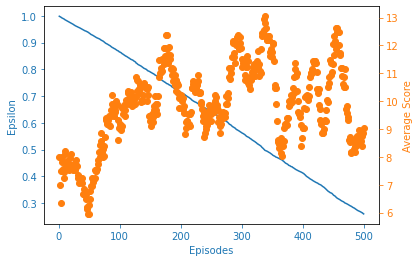

In [ ]:
x = [i+1 for i in range(len(scores))]
plot_learning_curve(x, scores, eps_history, figure_file)

## Evaluation

Finally, let's visualize our agent's performance, and play a game within the gym environment itself.

In [ ]:
#Visualization cobe for running within Colab

# Install dependencies first for graphics visualization within Colaboratory

#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1



Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (49.2.0)


In [ ]:
#To Evaluate model on OpenAI gym, we will record a video via Ipython display



from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
"""
shape = (84,84,1)
new_shape = (shape[2], shape[0], shape[1])
print(new_shape[1:])
#1,84,84

new_frame = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
resized_screen = cv2.resize(new_frame, self.shape[1:],
                                    interpolation=cv2.INTER_AREA)
new_obs = np.array(resized_screen, dtype=np.uint8).reshape(self.shape)
new_obs = new_obs / 255.0
"""


'\nshape = (84,84,1)\nnew_shape = (shape[2], shape[0], shape[1])\nprint(new_shape[1:])\n#1,84,84\n\nnew_frame = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)\nresized_screen = cv2.resize(new_frame, self.shape[1:],\n                                    interpolation=cv2.INTER_AREA)\nnew_obs = np.array(resized_screen, dtype=np.uint8).reshape(self.shape)\nnew_obs = new_obs / 255.0\n'

In [ ]:

class PreprocessFrameEval(gym.ObservationWrapper):
  #set shape by swapping channels axis
	#set observation space to new shape using gym.spaces.Box (0 to 1.0)
    def __init__(self, shape, env=None):
        super(PreprocessFrameEval, self).__init__(env)
        self.shape = (shape[2], shape[0], shape[1])
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0,
                                    shape=self.shape, dtype=np.float32)

    def observation(self, obs):
        img_array.append(obs)
        new_frame = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized_screen = cv2.resize(new_frame, self.shape[1:],
                                    interpolation=cv2.INTER_AREA)
        new_obs = np.array(resized_screen, dtype=np.uint8).reshape(self.shape)
        new_obs = new_obs / 255.0

        return new_obs



def make_envEVAL(env_name, shape=(84,84,1), repeat=4, clip_rewards=False,
             no_ops=0, fire_first=False):
    env = gym.make(env_name)
    env = PreprocessFrameEval(shape, env)
    env = RepeatActionAndMaxFrame(env, repeat, clip_rewards, no_ops, fire_first)
    
    env = StackFrames(env, repeat)

    return env

In [ ]:
env = make_envEVAL('VizdoomDefendLine-v0')

n_outputs = env.action_space.n
print(n_outputs)

img_array=[]

observation = env.reset()

#if load_checkpoint:
  #agent.load_models()


for i in range(2):
  done = False
  observation = env.reset()
  
  
  score = 0
  while not done:
    
    action = agent.choose_action(observation)
    observation_, reward, done, info = env.step(action)
    
    
    #img_array.append(observation)

3


906
(240, 320, 3)


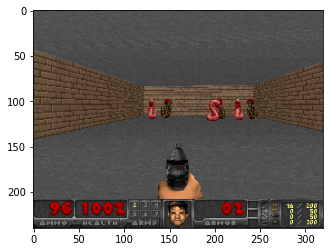

In [ ]:
print(len(img_array))

for i in range(22):
  
  if i > 20:
    print(img_array[i].shape)
    plt.imshow(img_array[i])
    plt.show()

 


In [ ]:
#!pip install sk-video


In [ ]:

from random import choice
import cv2 
from google.colab.patches import cv2_imshow
from torchvision.io import write_video

import numpy as np


out_video =  np.empty([len(img_array), 240, 320, 3], dtype = np.uint8)
out_video =  out_video.astype(np.uint8)

for i in range(len(img_array)):
  frame = img_array[i]
  out_video[i] = frame
# Writes the the output image sequences in a video file

write_video("/content/doom.mp4", out_video, 25, video_codec='libx264', options=None)
#skvideo.io.vwrite("/content/doom.mp4", out_video)
